# This notebook does initial exploration of time series models

In [16]:
# Imports

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import sys
sys.path.append("../")

In [2]:
%cd /pscratch/sd/m/mansisak/PatchTST/PatchTST_supervised

/pscratch/sd/m/mansisak/PatchTST/PatchTST_supervised


In [18]:
# Get model
from models.PatchTST import Model

class model_args:
    enc_in = 7
    seq_len = 336
    pred_len = 96

    e_layers = 3

    n_heads = 8
    d_model = 16
    d_ff = 128
    dropout = 0.05
    fc_dropout =  0.05
    head_dropout = 0.0

    individual = 0

    patch_len = 16
    stride = 8
    padding_patch = "end"

    revin = 1
    affine = 0
    subtract_last = 0

    decomposition = 0
    kernel_size = 25

model = Model(model_args)    
model

Model(
  (model): PatchTST_backbone(
    (revin_layer): RevIN()
    (padding_patch_layer): ReplicationPad1d((0, 8))
    (backbone): TSTiEncoder(
      (W_P): Linear(in_features=16, out_features=16, bias=True)
      (dropout): Dropout(p=0.05, inplace=False)
      (encoder): TSTEncoder(
        (layers): ModuleList(
          (0-2): 3 x TSTEncoderLayer(
            (self_attn): _MultiheadAttention(
              (W_Q): Linear(in_features=16, out_features=16, bias=True)
              (W_K): Linear(in_features=16, out_features=16, bias=True)
              (W_V): Linear(in_features=16, out_features=16, bias=True)
              (sdp_attn): _ScaledDotProductAttention(
                (attn_dropout): Dropout(p=0.0, inplace=False)
              )
              (to_out): Sequential(
                (0): Linear(in_features=16, out_features=16, bias=True)
                (1): Dropout(p=0.05, inplace=False)
              )
            )
            (dropout_attn): Dropout(p=0.05, inplace=False)
   

In [19]:
trained_model = "checkpoints/336_96_PatchTST_ETTh1_ftM_sl336_ll48_pl96_dm16_nh4_el3_dl1_df128_fc1_ebtimeF_dtTrue_Exp_0/checkpoint.pth"

model.load_state_dict(torch.load(trained_model, weights_only=True))

<All keys matched successfully>

In [20]:
# Get data
from data_provider.data_loader import Dataset_ETT_hour, Dataset_ETT_minute, Dataset_Custom, Dataset_Pred
from data_provider.data_factory import data_provider

#https://github.com/msakarvadia/PatchTST/blob/main/PatchTST_supervised/scripts/PatchTST/etth1.sh
class data_args:
    data = 'ETTh1' #TODO was "ETTm1"
    root_path = '/pscratch/sd/m/mansisak/PatchTST/PatchTST_supervised/dataset'
    data_path = 'ETTh1.csv'
    features = 'M'
    target = 'OT'
    freq = "h"
    embed = 'timeF'
    seq_len = 336 #336
    label_len = 96
    pred_len = 96
    num_workers = 1
    batch_size = 1

data_set, data_loader = data_provider(args=data_args, flag="test") #flag = pred | test | train

test 2785


# Decode intermediate model layers during inference

In [21]:
trained_model = "checkpoints/336_96_PatchTST_ETTh1_ftM_sl336_ll48_pl96_dm16_nh4_el3_dl1_df128_fc1_ebtimeF_dtTrue_Exp_0/checkpoint.pth"
model.load_state_dict(torch.load(trained_model, weights_only=True))


activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output
    return hook

num_layers = model_args.e_layers
for i in range(num_layers):
    model.model.backbone.encoder.layers[i].register_forward_hook(get_activation(f"layer_{i}_output"))

In [22]:
# inference on single data point
iter_count = 0
criterion = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(data_loader):
    iter_count += 1
    #model_optim.zero_grad()
    batch_x = batch_x.float().to(device)
    batch_y = batch_y.float().to(device)
    batch_x_mark = batch_x_mark.float().to(device)
    batch_y_mark = batch_y_mark.float().to(device)

    # decoder input
    dec_inp = torch.zeros_like(batch_y[:, data_args.pred_len:, :]).float()
    dec_inp = torch.cat([batch_y[:, :data_args.label_len, :], dec_inp], dim=1).float().to(device)

    outputs = model(batch_x)
    f_dim = 0
    outputs = outputs[:, -model_args.pred_len:, f_dim:]
    batch_y = batch_y[:, -model_args.pred_len:, f_dim:].to(device)
    pred = outputs.detach().cpu()
    true = batch_y.detach().cpu()
    loss = criterion(pred, true)
    print(loss)
    break
    

tensor(0.3448)


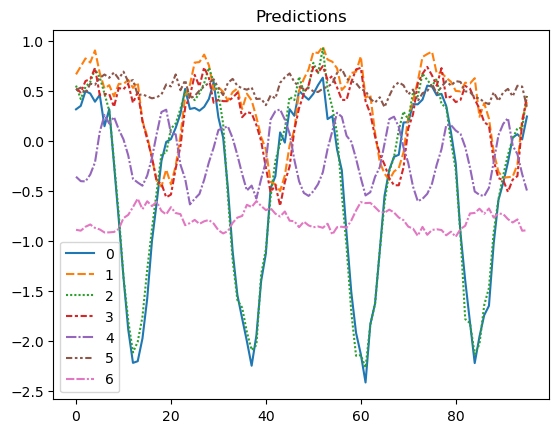

Text(0.5, 1.0, 'Labels')

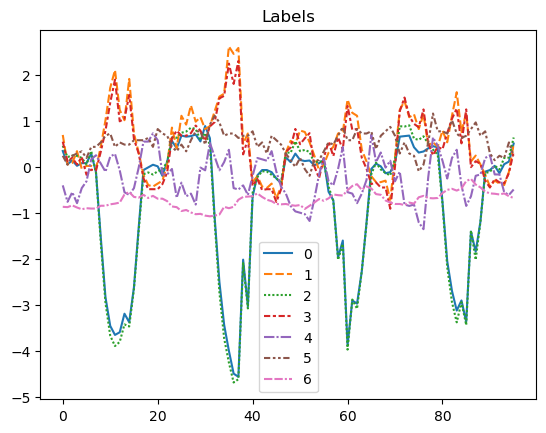

In [23]:
sns.lineplot(torch.mean(pred, dim=0))
plt.title("Predictions")
plt.show()
sns.lineplot(torch.mean(true, dim=0))
plt.title("Labels")

In [24]:
activation['layer_0_output'][-2].shape

torch.Size([7, 42, 16])

In [25]:
pred.shape

torch.Size([1, 96, 7])

In [26]:
model.model.head(batch).cpu().detach().numpy().shape

(7, 96)

In [27]:
batch = torch.zeros((128,7,42,16))
batch_original= batch
batch[:,1,:,:] = 1
batch = torch.reshape(batch, (128*7, 42,16))
new_batch= torch.reshape(batch, (128,7,42,16))

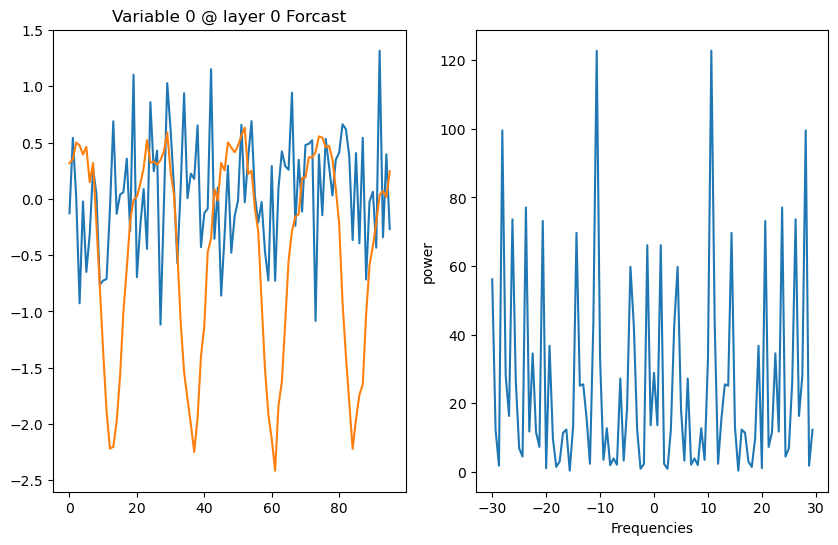

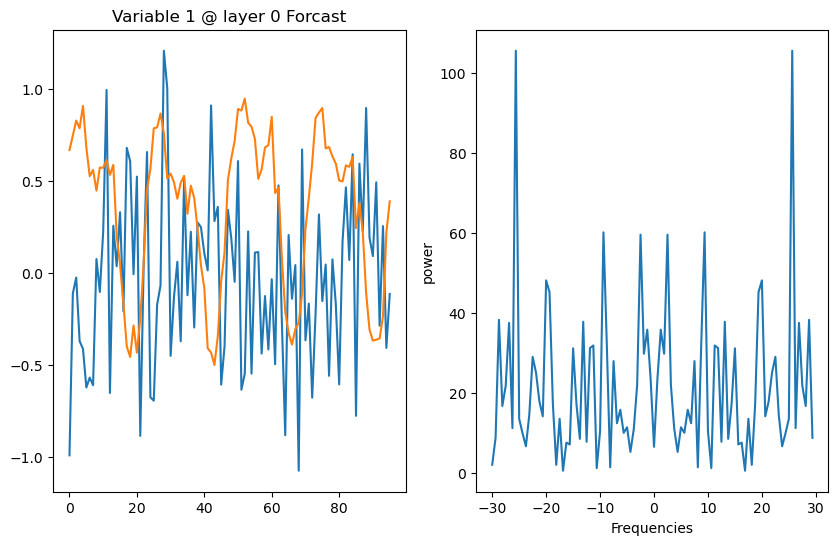

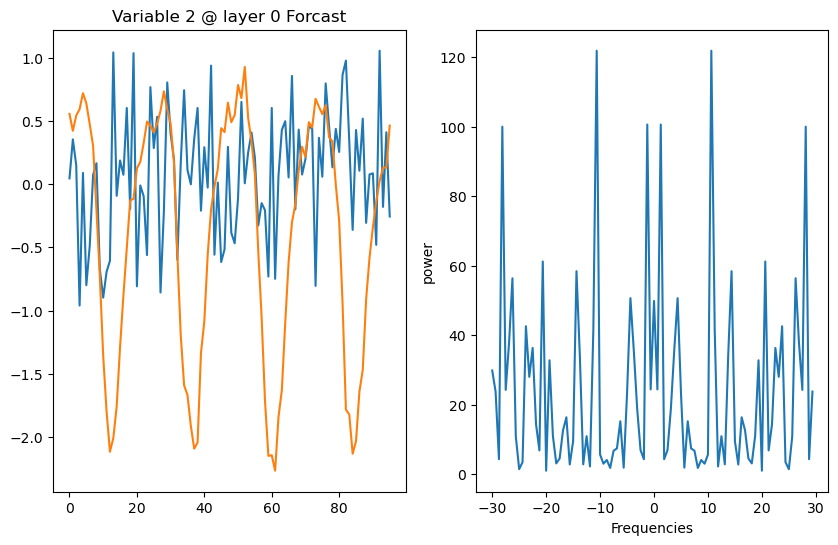

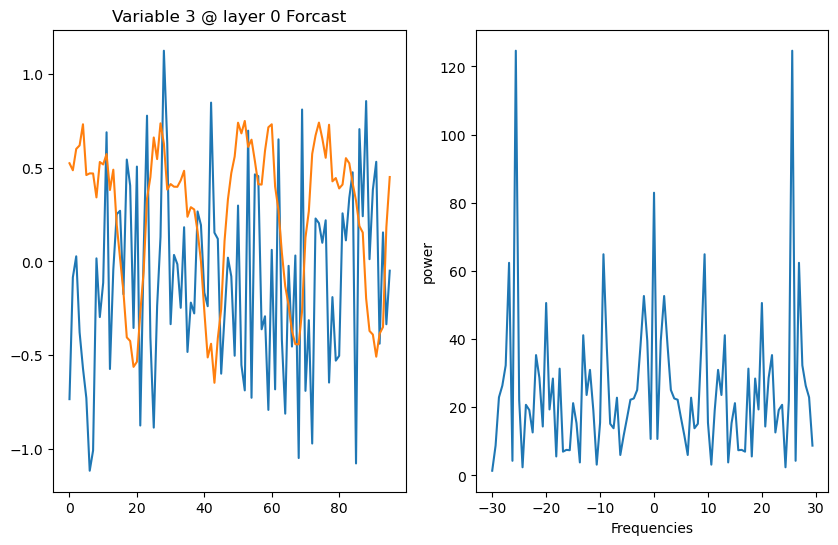

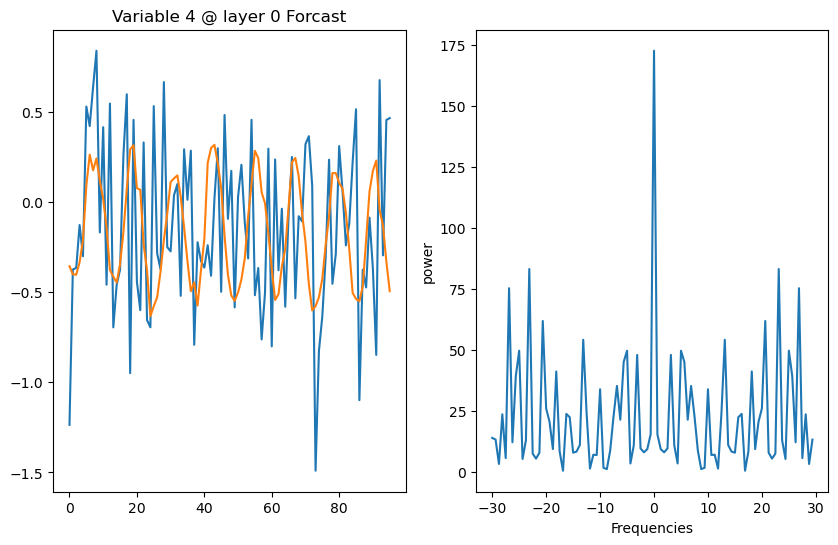

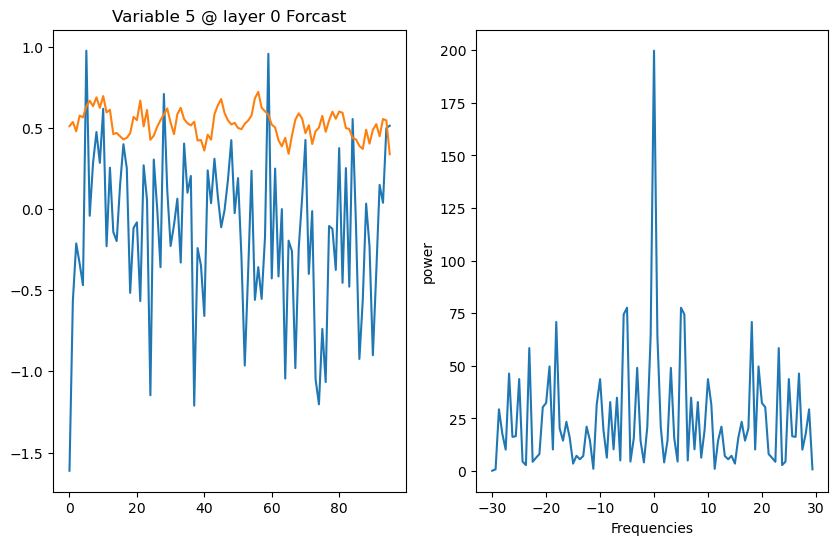

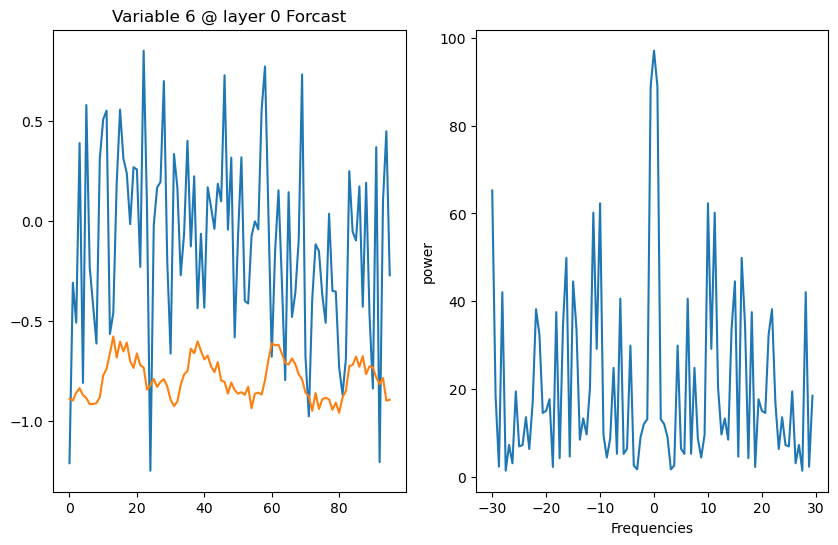

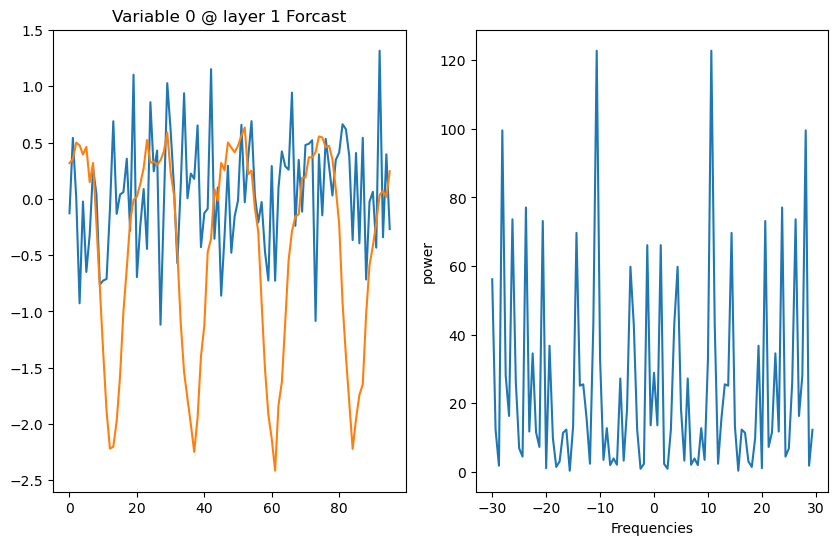

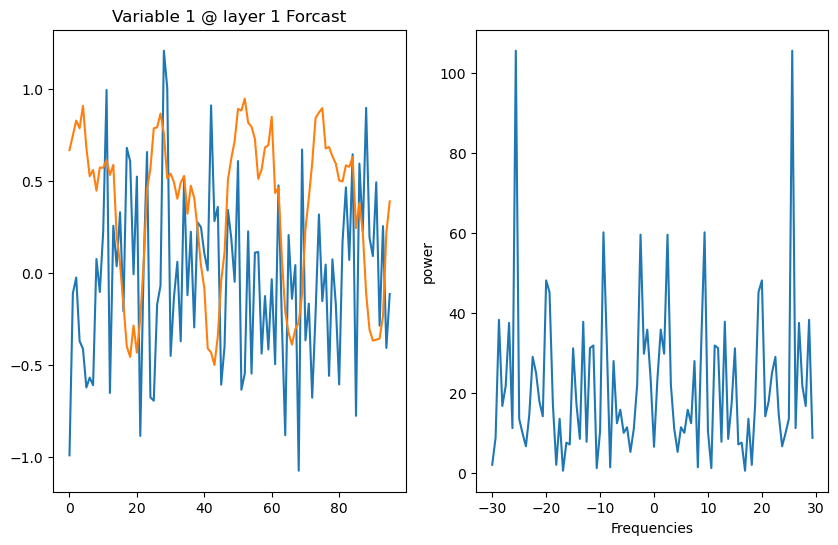

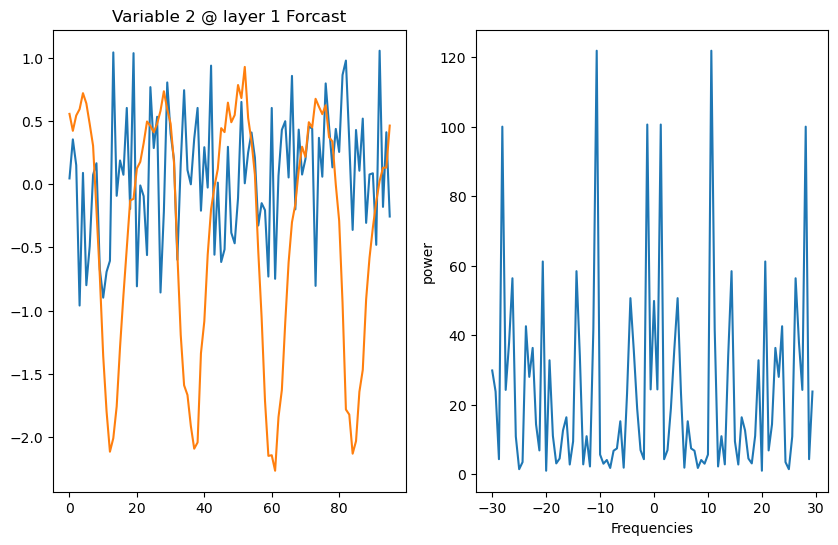

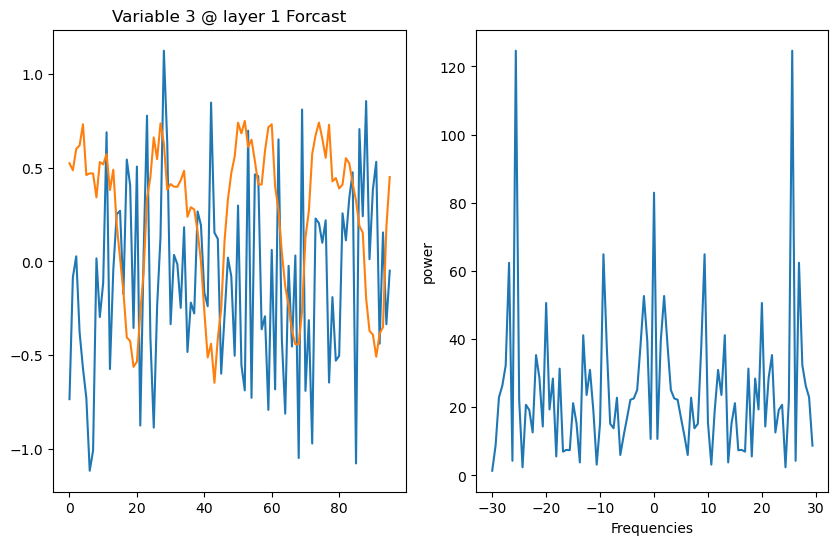

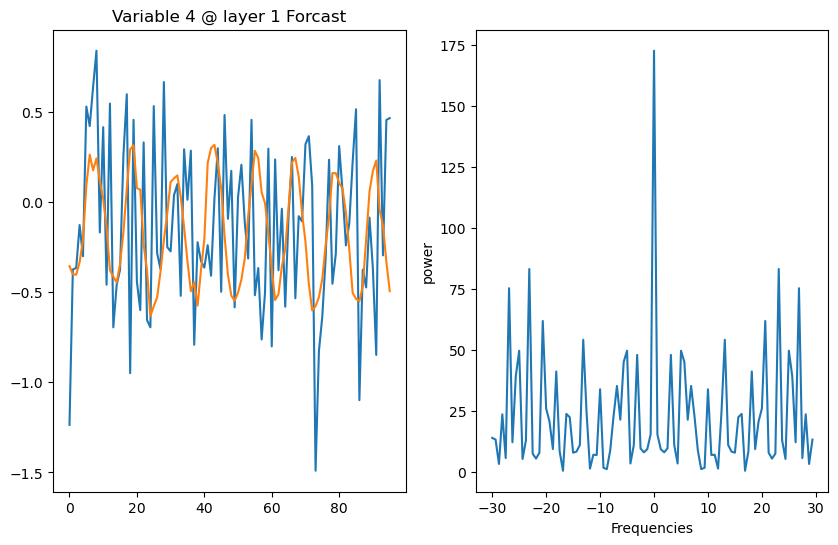

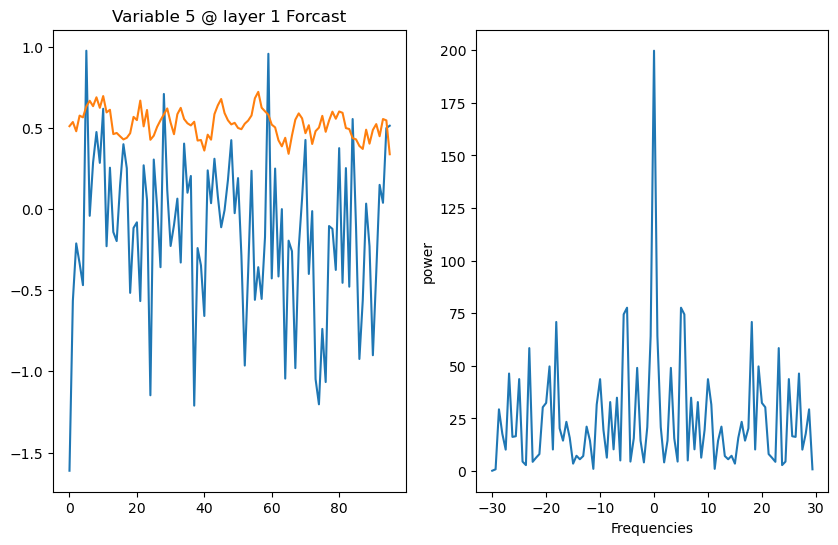

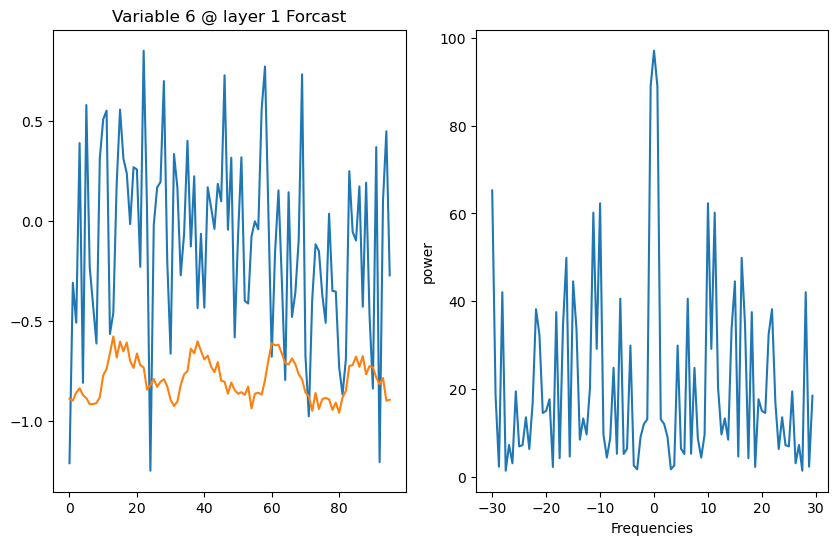

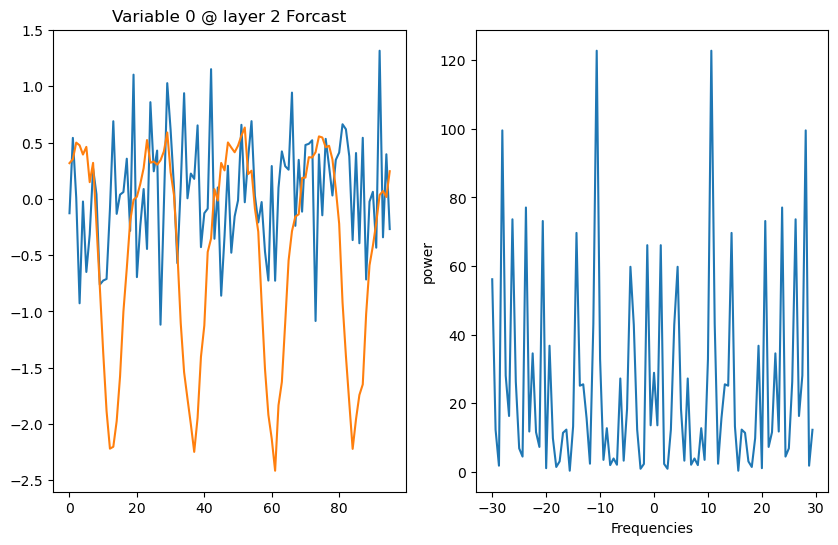

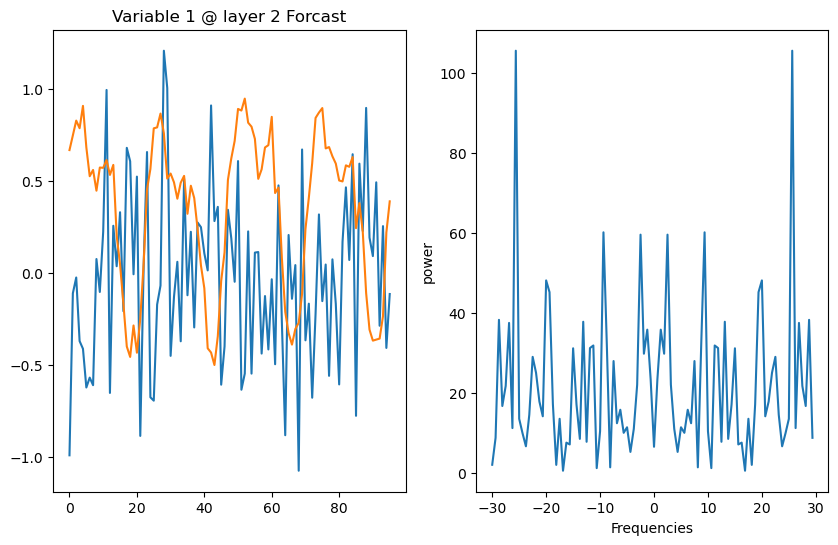

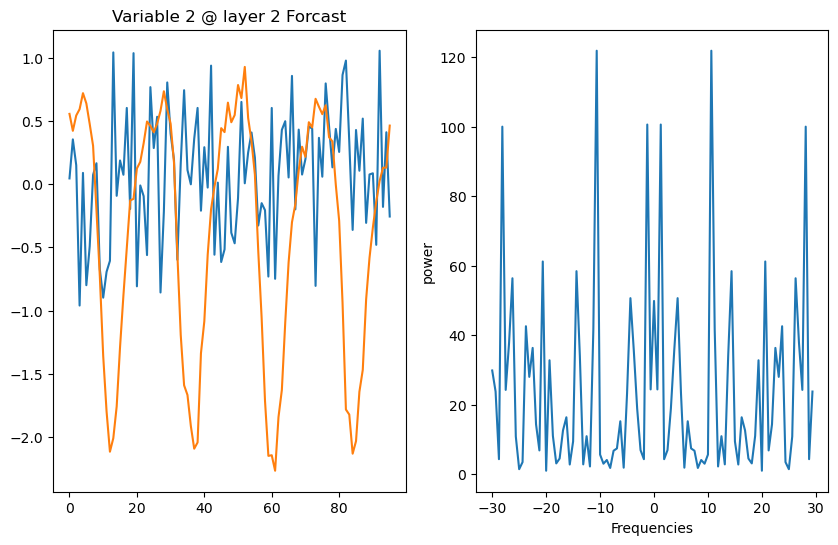

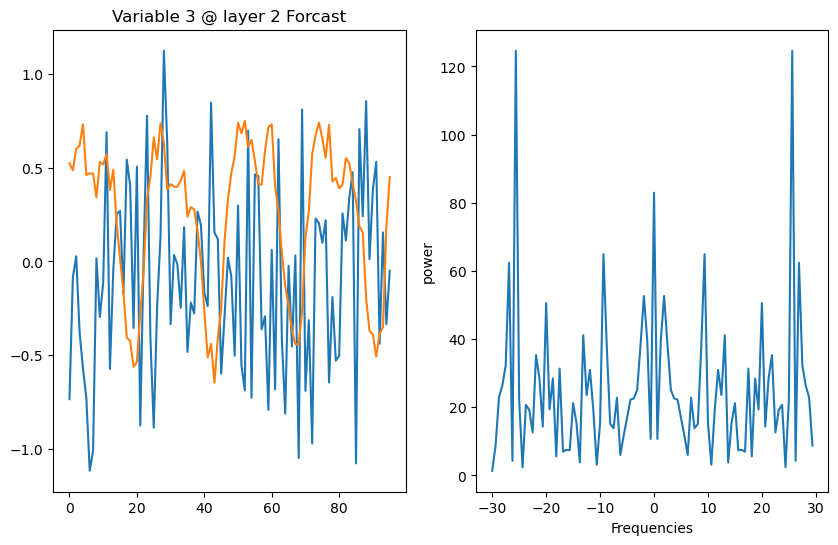

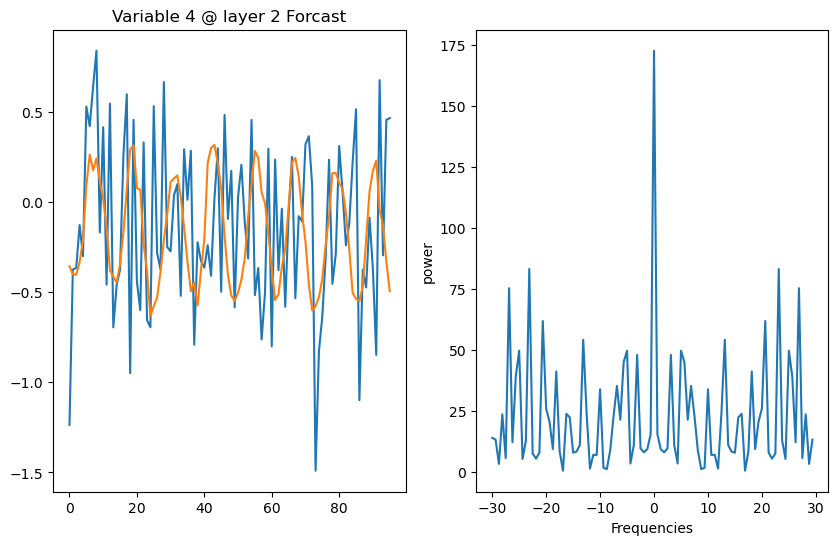

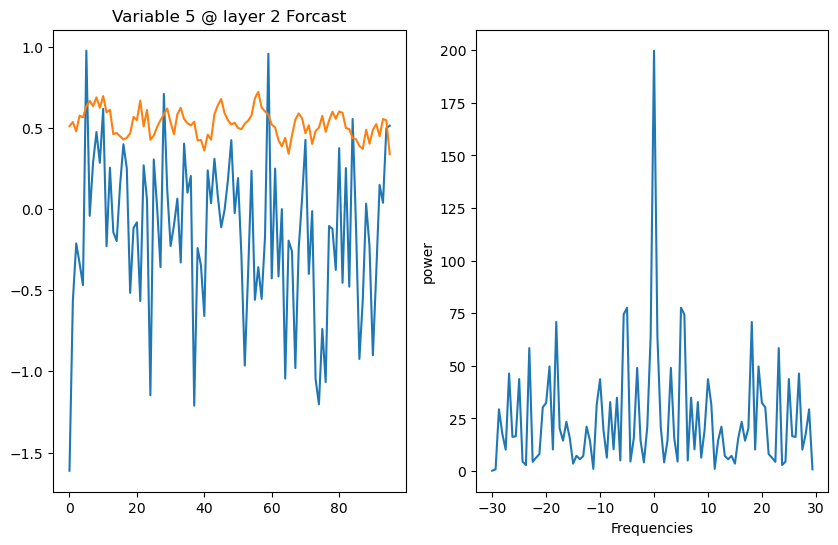

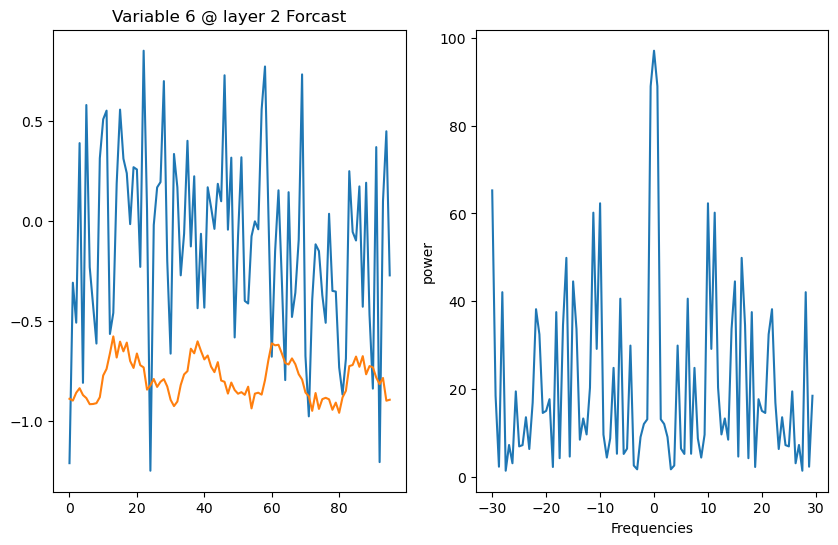

In [28]:


pred = torch.mean(pred, dim=0) #collapse batch dim

for j in range(num_layers):
    for i in range(7):
        fig, axs = plt.subplots( 1, 2, sharex="col", sharey=False, figsize=(10,6))
        batch= activation['layer_0_output'][-2] # bs*nvar x patch_size x d_model
        batch = torch.reshape(batch, (data_args.batch_size,7,42,16)) #bs x nvar x patch_size x d_model #TODO: verify that this reshape is faithful
        batch = torch.mean(batch, dim=0) # nvar x patch_size x d_model
        
        
        
        data = model.model.head(batch).cpu().detach().numpy()[i]
        ax = sns.lineplot(data, ax=axs[0])
        ax = sns.lineplot(pred[:,i], ax=axs[0])
        ax.set_title(f"Variable {i} @ layer {j} Forcast")
        
      
        ps = np.abs(np.fft.fft(data))**2 # This is the power spectrum density
        time_step = 1 / 60 # Random time step
        freqs = np.fft.fftfreq(data.size, time_step) #These are the frequences sampled every 1/30 time steps
        idx = np.argsort(freqs)
        axs[1] = plt.plot(freqs[idx], ps[idx])
        
        
        plt.xlabel("Frequencies")
        plt.ylabel("power")
        plt.show()

- Orange is the label
- Blue is the decoded signal at a given layer

- Need to do this for more than batch of 1 (need to ensure that the reshaping is faithful to how data is organized)

Below we do for a batch of 1280:

test 2785
tensor(0.3124)


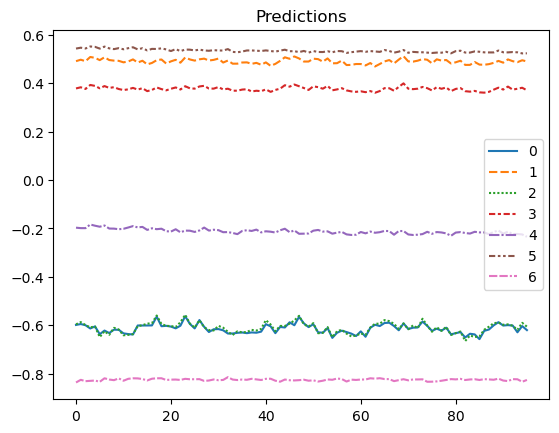

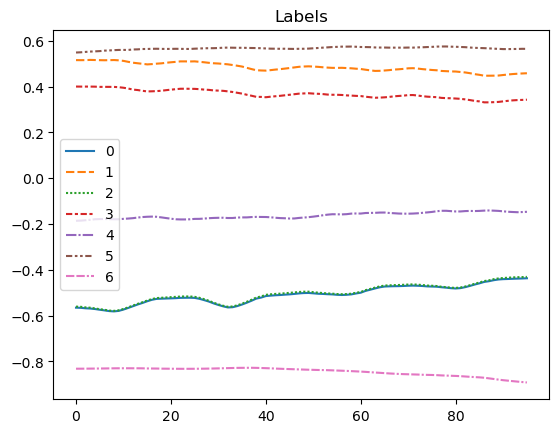

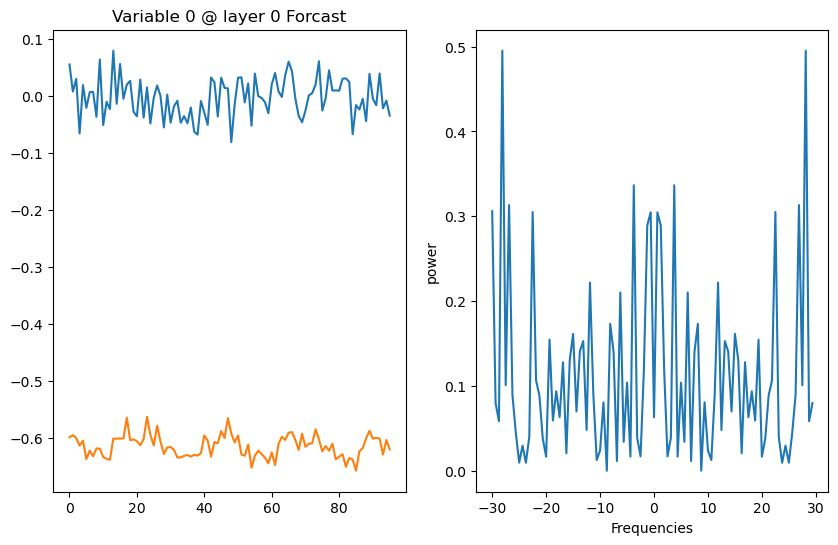

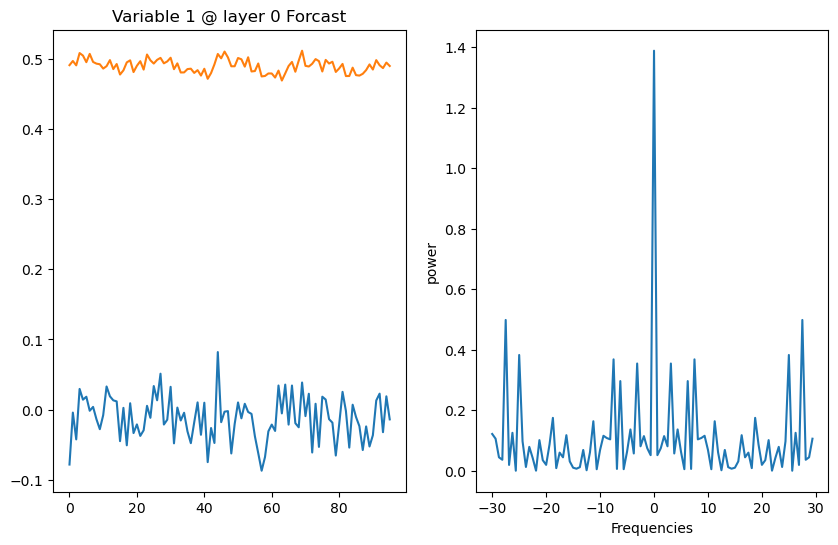

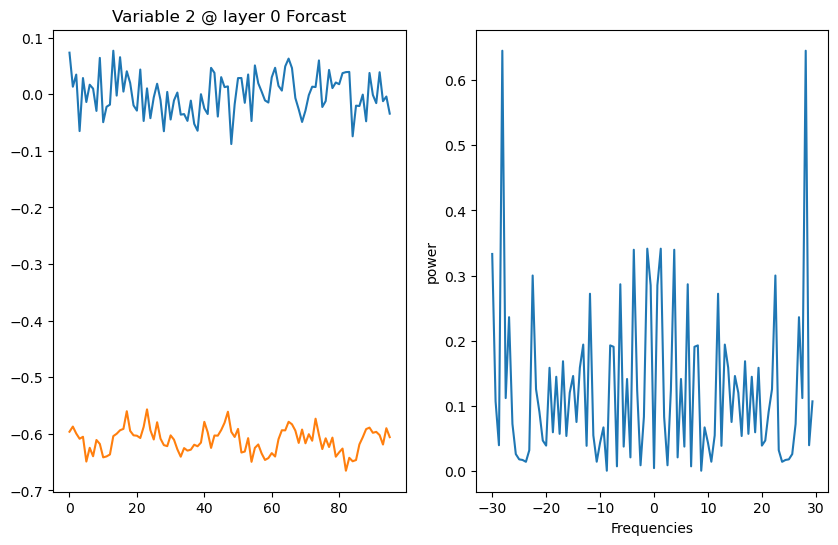

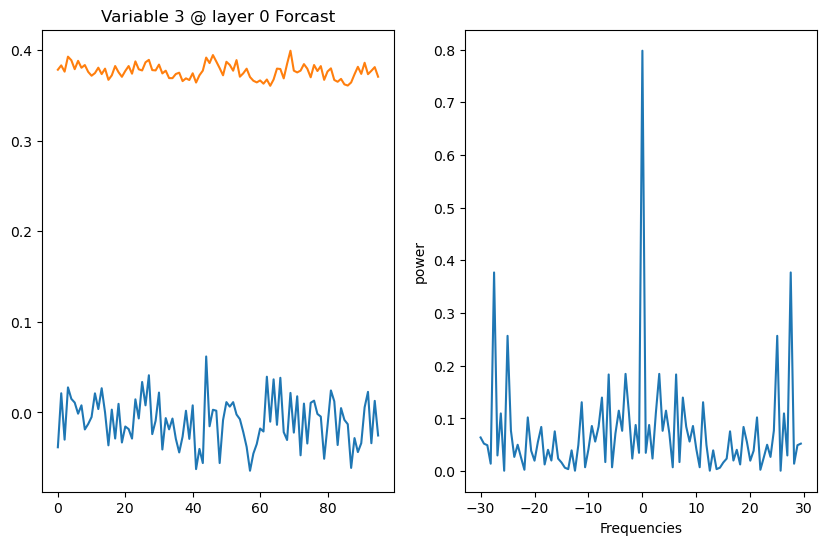

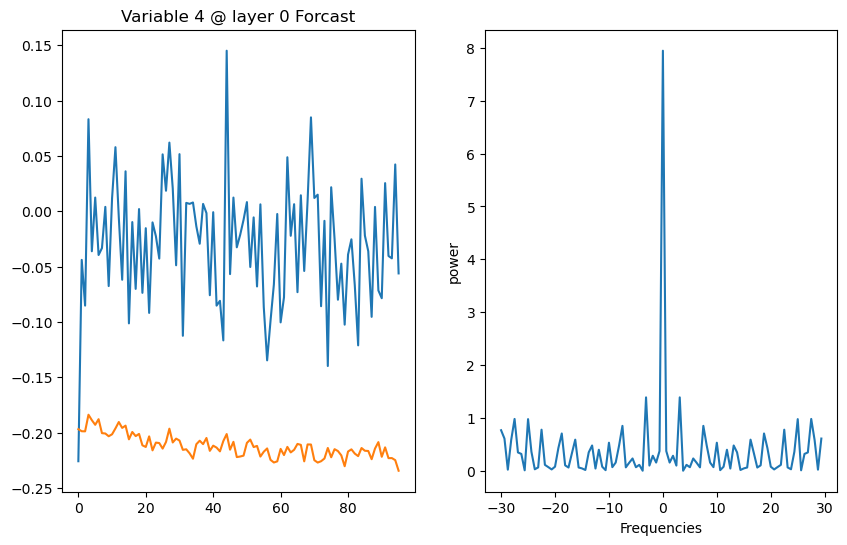

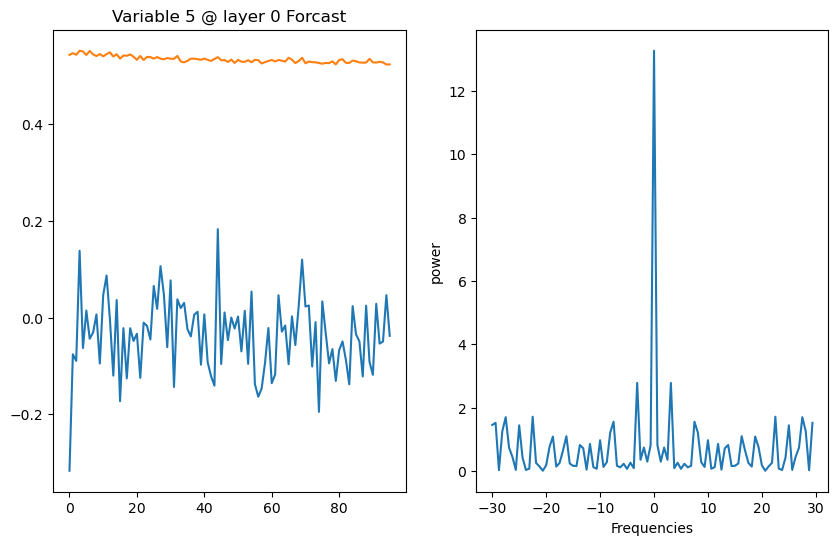

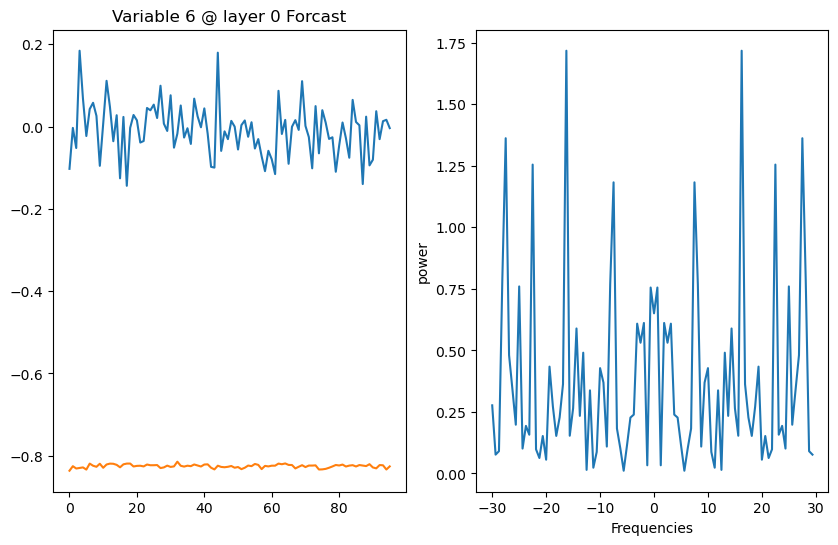

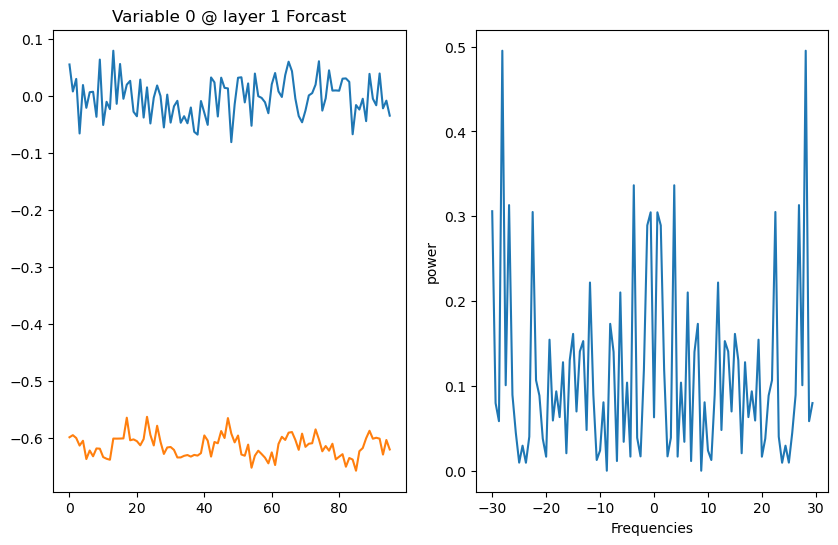

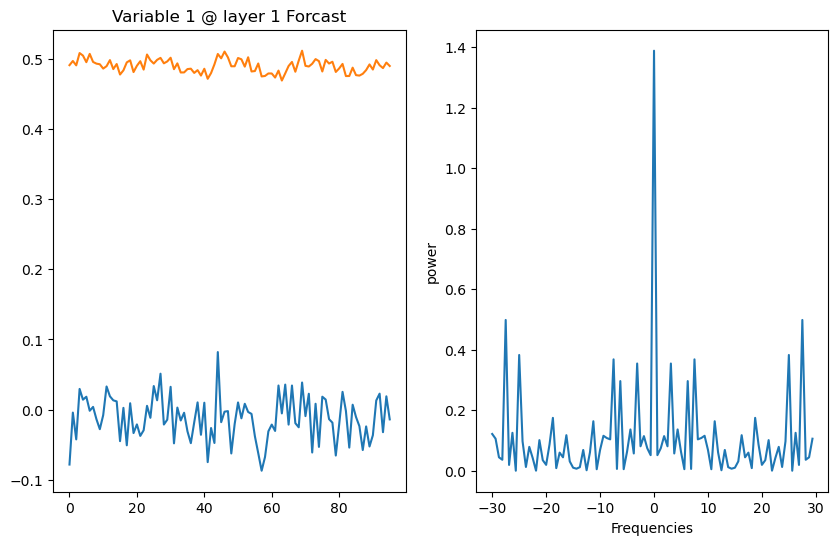

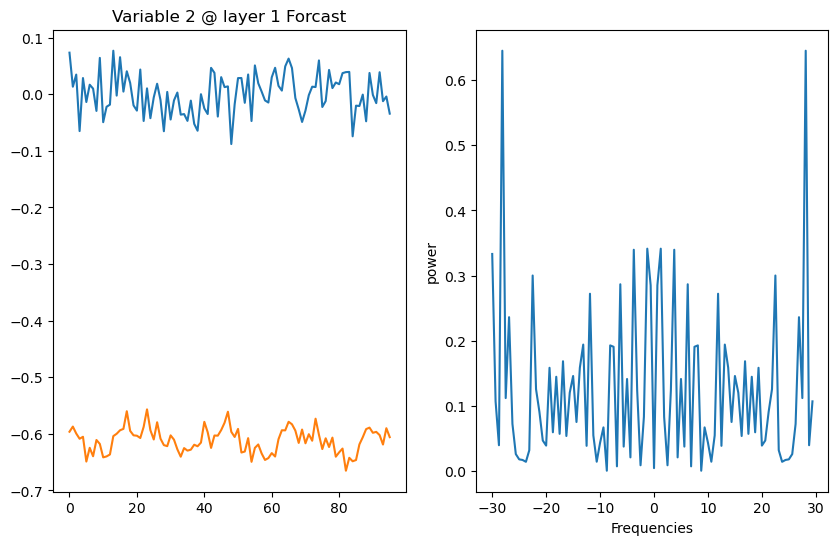

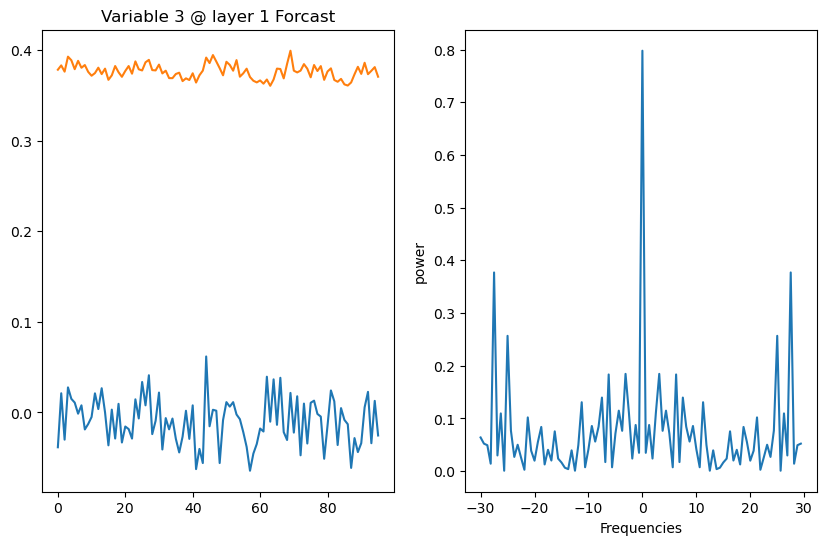

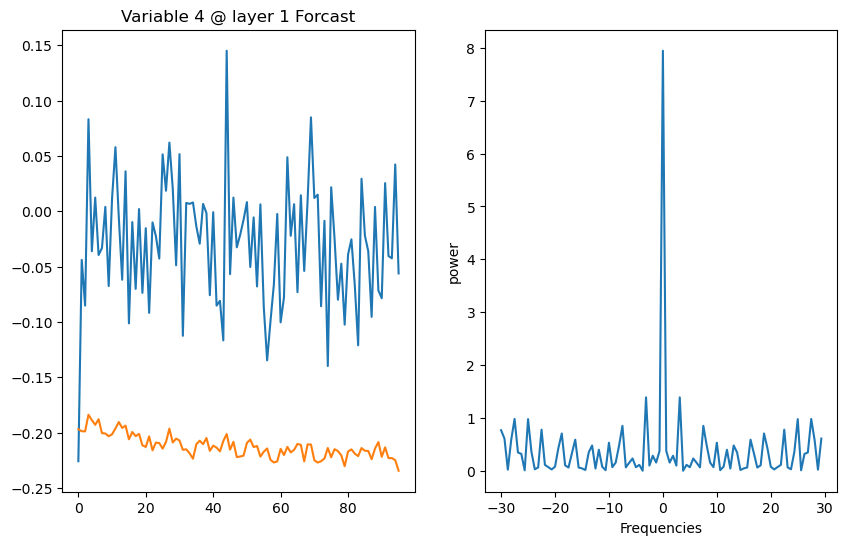

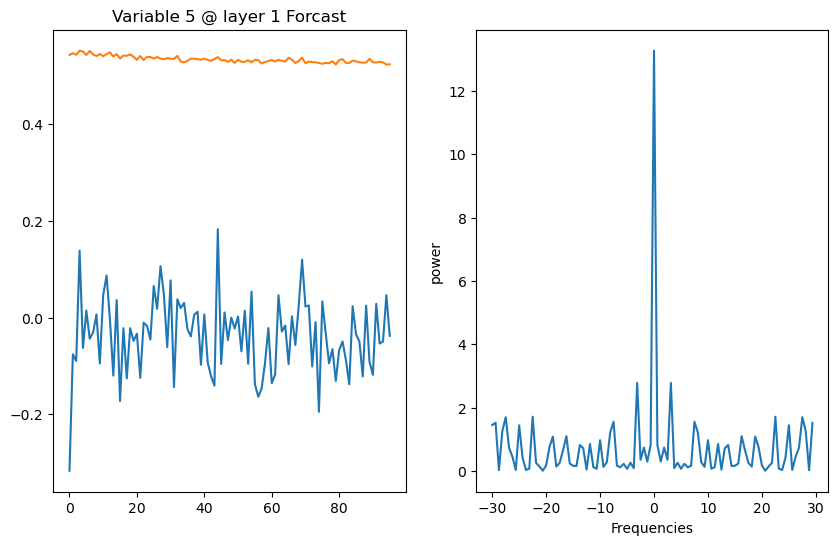

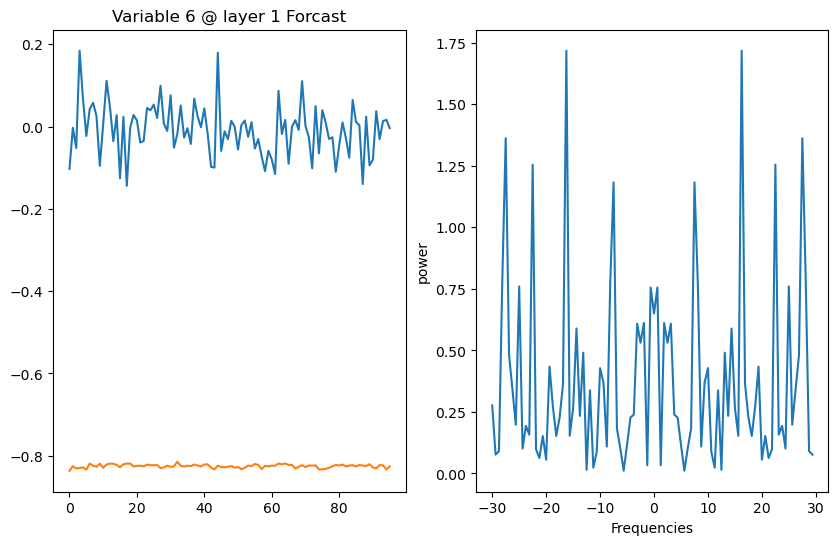

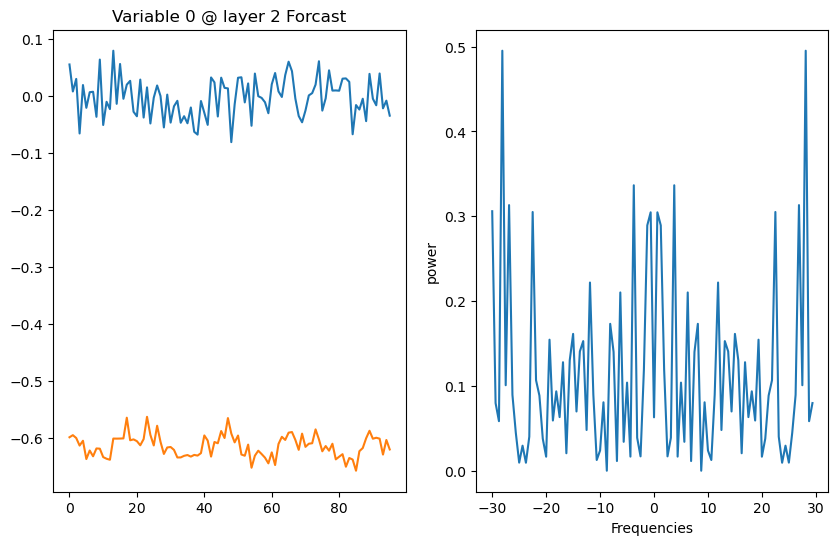

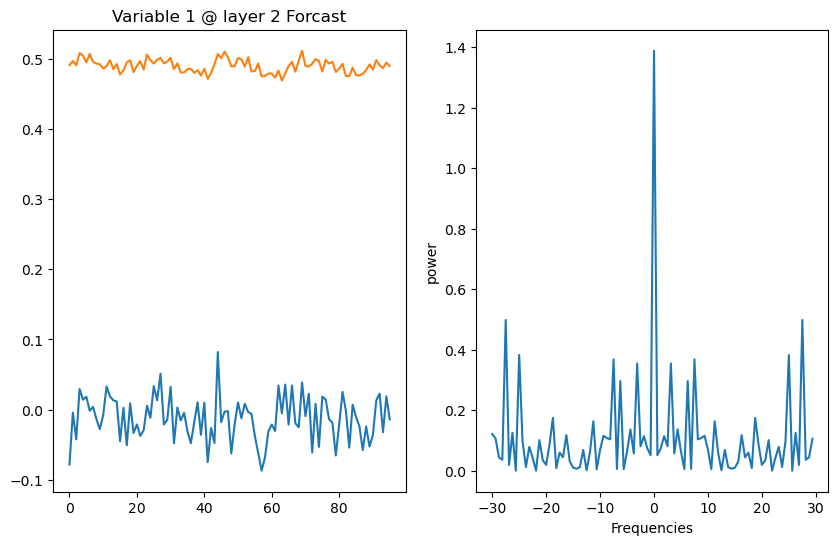

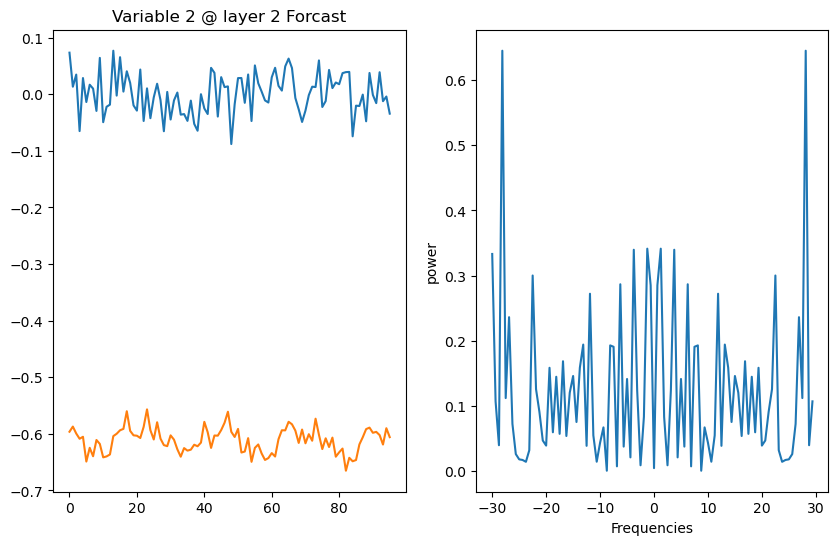

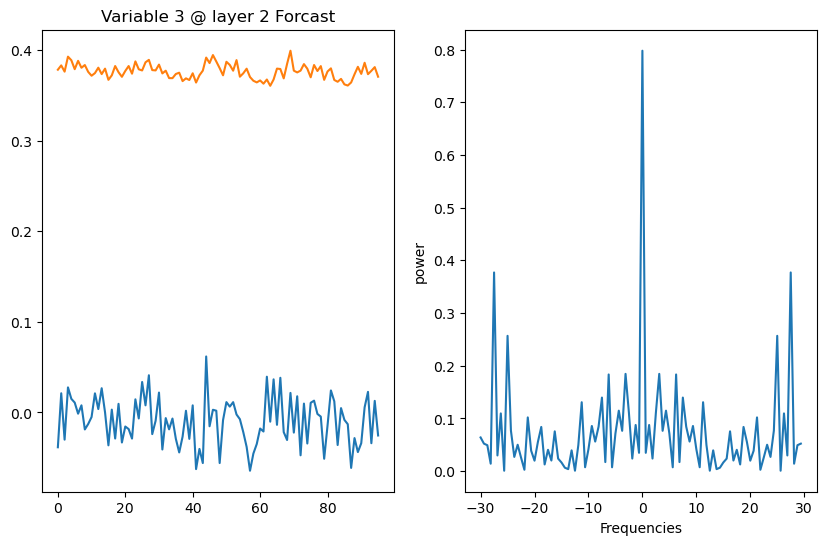

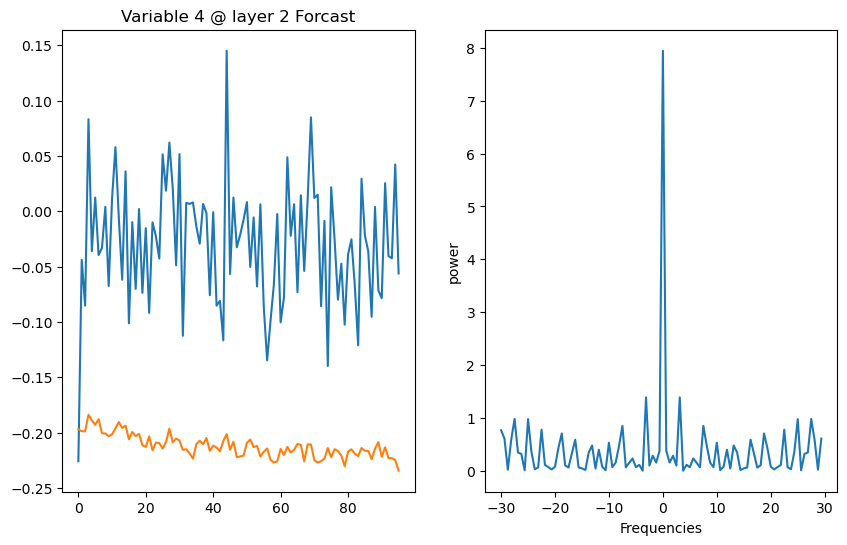

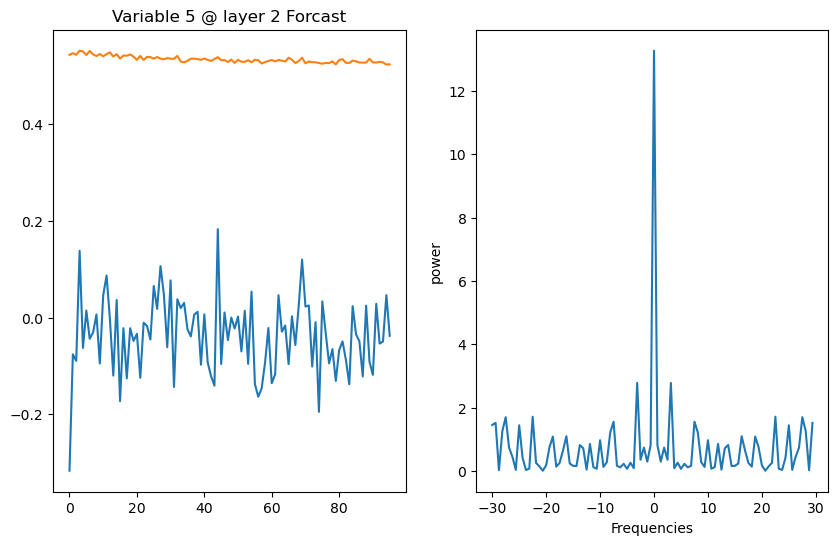

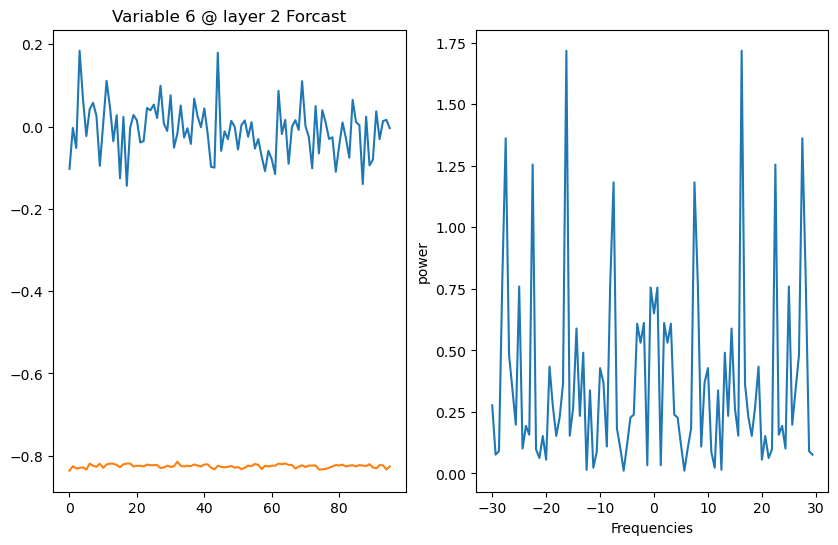

In [31]:
# Get data
from data_provider.data_loader import Dataset_ETT_hour, Dataset_ETT_minute, Dataset_Custom, Dataset_Pred
from data_provider.data_factory import data_provider

#https://github.com/msakarvadia/PatchTST/blob/main/PatchTST_supervised/scripts/PatchTST/etth1.sh
class data_args:
    data = 'ETTh1' #TODO was "ETTm1"
    root_path = '/pscratch/sd/m/mansisak/PatchTST/PatchTST_supervised/dataset'
    data_path = 'ETTh1.csv'
    features = 'M'
    target = 'OT'
    freq = "h"
    embed = 'timeF'
    seq_len = 336 #336
    label_len = 96
    pred_len = 96
    num_workers = 1
    batch_size = 512

data_set, data_loader = data_provider(args=data_args, flag="test") #flag = pred | test | train

trained_model = "checkpoints/336_96_PatchTST_ETTh1_ftM_sl336_ll48_pl96_dm16_nh4_el3_dl1_df128_fc1_ebtimeF_dtTrue_Exp_0/checkpoint.pth"
model.load_state_dict(torch.load(trained_model, weights_only=True))


activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output
    return hook

num_layers = model_args.e_layers
for i in range(num_layers):
    model.model.backbone.encoder.layers[i].register_forward_hook(get_activation(f"layer_{i}_output"))


# inference on single data point
iter_count = 0
criterion = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(data_loader):
    iter_count += 1
    #model_optim.zero_grad()
    batch_x = batch_x.float().to(device)
    batch_y = batch_y.float().to(device)
    batch_x_mark = batch_x_mark.float().to(device)
    batch_y_mark = batch_y_mark.float().to(device)

    # decoder input
    dec_inp = torch.zeros_like(batch_y[:, data_args.pred_len:, :]).float()
    dec_inp = torch.cat([batch_y[:, :data_args.label_len, :], dec_inp], dim=1).float().to(device)

    outputs = model(batch_x)
    f_dim = 0
    outputs = outputs[:, -model_args.pred_len:, f_dim:]
    batch_y = batch_y[:, -model_args.pred_len:, f_dim:].to(device)
    pred = outputs.detach().cpu()
    true = batch_y.detach().cpu()
    loss = criterion(pred, true)
    print(loss)
    break
    
sns.lineplot(torch.mean(pred, dim=0))
plt.title("Predictions")
plt.show()
sns.lineplot(torch.mean(true, dim=0))
plt.title("Labels")

import matplotlib.pyplot as plt
import seaborn as sns

pred = torch.mean(pred, dim=0) #collapse batch dim

for j in range(num_layers):
    for i in range(7):
        fig, axs = plt.subplots( 1, 2, sharex="col", sharey=False, figsize=(10,6))
        batch= activation['layer_0_output'][-2] # bs*nvar x patch_size x d_model
        batch = torch.reshape(batch, (data_args.batch_size,7,42,16)) #bs x nvar x patch_size x d_model #TODO: verify that this reshape is faithful
        batch = torch.mean(batch, dim=0) # nvar x patch_size x d_model
        
        
        
        data = model.model.head(batch).cpu().detach().numpy()[i]
        ax = sns.lineplot(data, ax=axs[0])
        ax = sns.lineplot(pred[:,i], ax=axs[0])
        ax.set_title(f"Variable {i} @ layer {j} Forcast")
        
      
        ps = np.abs(np.fft.fft(data))**2 # This is the power spectrum density
        time_step = 1 / 60 # Random time step
        freqs = np.fft.fftfreq(data.size, time_step) #These are the frequences sampled every 1/30 time steps
        idx = np.argsort(freqs)
        axs[1] = plt.plot(freqs[idx], ps[idx])
        
        
        plt.xlabel("Frequencies")
        plt.ylabel("power")
        plt.show()